# S1 Coursework - Part D

In [1]:
import numpy as np
from tabulate import tabulate
import pandas as pd
import timeit
np.random.seed(10)

# Import overall distribution which is a combination of the signal and background distributions
from Stats_Analysis import Signal_Background

## Load base class (Distribution)

In [2]:
# Parameters for Crystal Ball distribution
mean = 3
sigma = 0.3
beta = 1
m = 1.4

# Parameters for Exponential Decay distribution
lamb = 0.3

# Parameters for Normal distribution
mean_b = 0
sigma_b = 2.5

# Parameters for fraction of signal
f = 0.6

# Parameters
x_lower_trunc = 0
x_upper_trunc = 5
y_lower_trunc = 0
y_upper_trunc = 10

# Parameters in a table
print("Overall Distribution Parameters")

parameters = {
    "Part": ["Signal", "Signal", "Signal", "Signal", "Signal", "Background", "Background", "Background", "Overall", "Truncation",  "Truncation",  "Truncation",  "Truncation"],
    "Distribution": ["Crystal Ball", "Crystal Ball", "Crystal Ball", "Crystal Ball", "Exponential Decay", "Uniform", "Normal", "Normal", '', "Truncation",  "Truncation",  "Truncation",  "Truncation"],
    "Parameter": ["Mean", "Sigma", "Beta", "M", "Lambda", "N/A", "Mean", "Sigma", "Fraction" ,"X Lower", "X Upper", "Y Lower", "Y Upper"],
    "Value": [mean, sigma, beta, m, lamb,'N/A', mean_b, sigma_b, f,  x_lower_trunc, x_upper_trunc, y_lower_trunc, y_upper_trunc]
}
df = pd.DataFrame(parameters)
print(df.to_markdown(index=False))

# Declare the overall distribution with parameters
overall = Signal_Background(mean, sigma, beta, m, lamb, mean_b, sigma_b, f, x_lower_trunc, x_upper_trunc, y_lower_trunc, y_upper_trunc)

Overall Distribution Parameters
| Part       | Distribution      | Parameter   | Value   |
|:-----------|:------------------|:------------|:--------|
| Signal     | Crystal Ball      | Mean        | 3       |
| Signal     | Crystal Ball      | Sigma       | 0.3     |
| Signal     | Crystal Ball      | Beta        | 1       |
| Signal     | Crystal Ball      | M           | 1.4     |
| Signal     | Exponential Decay | Lambda      | 0.3     |
| Background | Uniform           | N/A         | N/A     |
| Background | Normal            | Mean        | 0       |
| Background | Normal            | Sigma       | 2.5     |
| Overall    |                   | Fraction    | 0.6     |
| Truncation | Truncation        | X Lower     | 0       |
| Truncation | Truncation        | X Upper     | 5       |
| Truncation | Truncation        | Y Lower     | 0       |
| Truncation | Truncation        | Y Upper     | 10      |
Maximum PDF value found: 0.21804724534774383


## Part D

### Generating High Statistic Sample - Accept Reject 
- This class uses a vectorised version of accept-reject inorder to generate samples in as few as steps possible

### Key Features:
- **Dynamic Batch Sizing:** Adjusts the batch size based on the acceptance rate to optimise performance.
- **Maximum PDF Value:** Pre-calculated during distribution initialisation so can be used to increase accept reject efficiency.
- **Poisson Sample Size:** Supports generating samples with Poisson distributed counts if desired.

#### Function: `accept_reject_sample(desired_samples, init_batch_size, max_batch_size, poisson, save_to_class)`

#### Steps Overview:

1. **Initial Batch Generation:**
   - Generate a batch of `init_batch_size` data points (default: 1,000) uniformly within the truncated region.
   - Evaluate the PDF for these points and determine whether each point is accepted or rejected using the accept-reject condition.
   - Store accepted points.

2. **Acceptance Rate Estimation:**
   - Calculate the acceptance rate:
     $
     \text{acceptance\_rate} = \frac{\text{Number of Accepted Points}}{\text{init\_batch\_size}}
     $

3. **Dynamic Batch Generation:**
   - Determine the number of remaining samples needed to reach `desired_samples`.
   - Calculate the batch size using:
     $
     \text{batch\_size} = \min\left(\frac{\text{Remaining Samples}}{\text{acceptance\_rate}} \times 1.1, \text{max\_batch\_size}\right)
     $
   - The factor of 1.1 ensures a slight overestimation to reduce the number of iterations (ideally 1) due to statistical fluctuations.
   - The `max_batch_size` (default: 2 million) is there to stop memory overflow

4. **Iterative Sampling:**
   - Generate a batch of data points and perform the accept-reject method to collect additional samples.
   - Repeat this process until the total number of accepted samples meets or exceeds `desired_samples`.

[Relavent Code and Documentation for Accept Reject Samples](https://s1-coursework.readthedocs.io/en/latest/Stats_Analysis/Compound_Dist/Signal_Background_Class.html#Stats_Analysis.Compound_Dist.Signal_Background_Class.Signal_Background.accept_reject_sample)

### Generating 100,000 samples




In [3]:
generated_samples = overall.accept_reject_sample(desired_samples=100000, init_batch_size=1000, max_batch_size=2000000, poisson = False, save_to_class=False)

### Plot 100,000 samples against original distribution
- Below these generated samples are plotted to verify the method

[Relavent Code and Documentation for Plotting Generated Samples](https://s1-coursework.readthedocs.io/en/latest/Stats_Analysis/Compound_Dist/Signal_Background_Class.html#Stats_Analysis.Compound_Dist.Signal_Background_Class.Signal_Background.plot_samples)

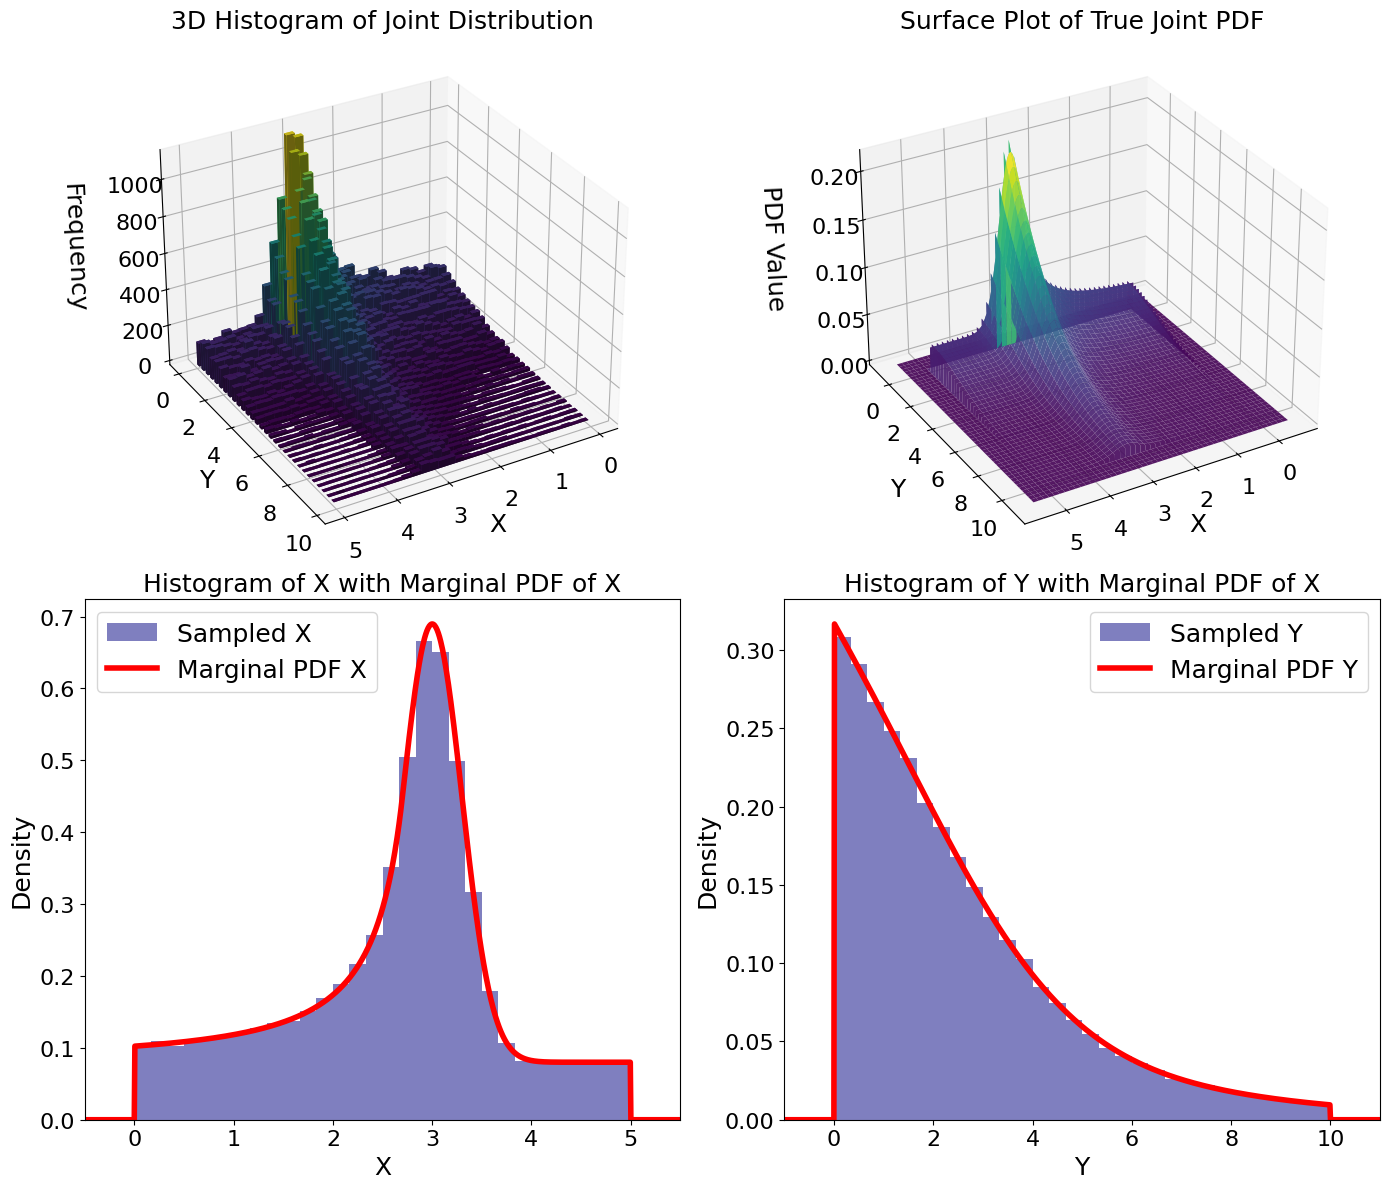

In [4]:
overall.plot_samples(samples=generated_samples)

### Estimating Parameters from Samples

- The samples is then fitted using **Extended Unbinned Maximium Likelihood Fitting** through the `iminuit package`
- **Unbinned MLE** is chosen as it is able to produce results sufficently fast while preserving all the information in the dataset - this is true for parametric bootstrapping in Part e
- **Binned MLE** could be implemented if higher computational efficiency or larger scale samples/ bootstrapping was required

#### Method
- Each Distribution Class also contains a `pdf_fitting()` function which allows iminuit to calculate pdf at arbitary paramaters to minimise likelihood, these a build up in a moduluar structure similiar to before
- Parameter limits have been set for the distribution to restricit iminuits search area to physical meaningful parameter space

    | Parameter   | Limit Range              |
    |-------------|--------------------------|
    | `sigma`     | (1e-3, None)            | 
    | `beta`      | (1e-2, None)            | 
    | `m`         | (1.01, None)            | 
    | `lamb`      | (1e-3, None)            | 
    | `sigma_b`   | (1e-3, None)            | 
    | `f`         | (0, 1)                  | 
    | `No. Samples`| (1e-3, None)           | 
- The fit takes an array of `initial_parameter` guesses in the format
    - [mu, sigma, beta, m, lamb, mu_b, sigma_b, f, N_expected]

[Relavent Code and Documentation for Extended MLE fitting](https://s1-coursework.readthedocs.io/en/latest/Stats_Analysis/Compound_Dist/Signal_Background_Class.html#Stats_Analysis.Compound_Dist.Signal_Background_Class.Signal_Background.fit_params)

#### Further Analysis - Comparison and Profile LogLikelihoods
- Fitted fits can be stored within the class for further analysis.
- The corrolation matri 
- The `mnprofile` of `iminuit` allows:
    - Plotting of rofile log-likelihood scans for each parameter.
    - Visualiaation of the double-sided error ranges for key parameters.

### Fitting to 100,000 samples

In [5]:
# Initial guesses - slightly off from the true values
initial_params = [3.1, 0.4, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7, 99900]

# Fit to the overall distribution
overall.fit_params(initial_params, samples = generated_samples, print_results = True, save_to_class = True)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 358              │
│ EDM = 0.000108 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

(<ValueView mu=2.997547880751567 sigma=0.30376046151229297 beta=0.9933283275445319 m=1.3684536290716693 lamb=0.30449116108086305 mu_b=0.07102720361813632 sigma_b=2.482697558402785 f=0.6049836940693363 N=99999.95996373323>,
 <ErrorView mu=0.0026513098628898396 sigma=0.002482070009911963 beta=0.023055793517043566 m=0.06346504974779577 lamb=0.002067854864777341 mu_b=0.0768876046093945 sigma_b=0.03615833952281422 f=0.0035840944809528152 N=316.20447636285826>)

### Analysis on Fitting

#### Comparision with true results and corrolation matrix

[Relavent Code and Documentation for display of fit results](https://s1-coursework.readthedocs.io/en/latest/Stats_Analysis/Compound_Dist/Signal_Background_Class.html#Stats_Analysis.Compound_Dist.Signal_Background_Class.Signal_Background.fit_params_results)



+-----------------------+-----------+-----------------------+------------+---------------------+
|     Distribution      | Parameter |     Value ± Error     | True Value |   Std Errors Away   |
+-----------------------+-----------+-----------------------+------------+---------------------+
| Crystal Ball (Signal) |    mu     |    2.9975 ± 0.0027    |     3      | 0.9248708658142569  |
| Crystal Ball (Signal) |   sigma   |    0.3038 ± 0.0025    |    0.3     | 1.5150505413932136  |
| Crystal Ball (Signal) |   beta    |    0.9933 ± 0.0231    |     1      | 0.2893707583968498  |
| Crystal Ball (Signal) |     m     |    1.3685 ± 0.0635    |    1.4     | 0.49706682739071234 |
| Exponential (Signal)  |   lamb    |    0.3045 ± 0.0021    |    0.3     | 2.1718937616768628  |
|  Normal (Background)  |   mu_b    |    0.0710 ± 0.0769    |     0      | 0.9237796388503676  |
|  Normal (Background)  |  sigma_b  |    2.4827 ± 0.0362    |    2.5     | 0.47851869929751994 |
|        Overall        |     

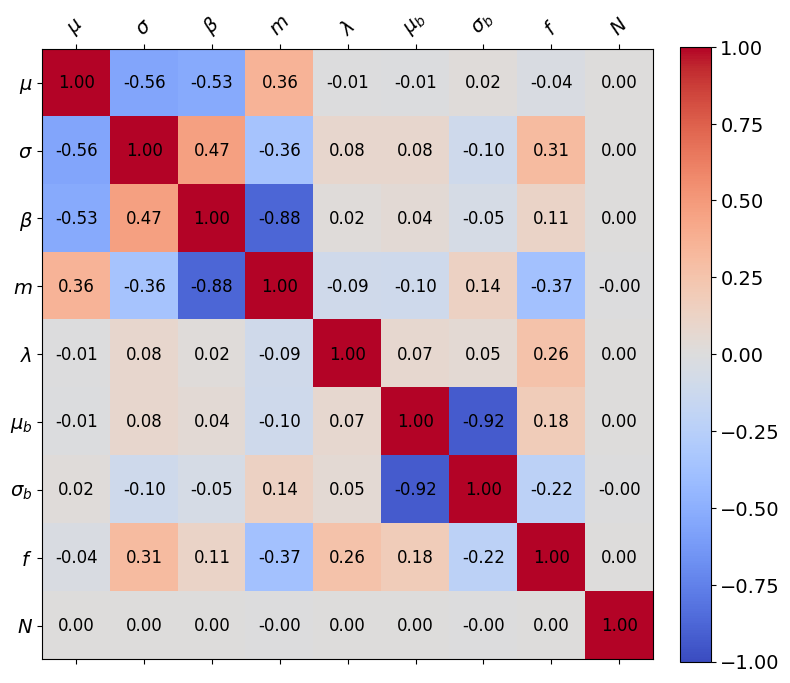

In [6]:
# Fitting results
overall.fit_params_results()

#### Profiles Log Likelihoods

[Relavent Code and Documentation for display of Mi's NLL profiles](https://s1-coursework.readthedocs.io/en/latest/Stats_Analysis/Compound_Dist/Signal_Background_Class.html#Stats_Analysis.Compound_Dist.Signal_Background_Class.Signal_Background.plot_profiled_likelihoods)

Plotting profile for mu
Plotting profile for sigma
Plotting profile for beta
Plotting profile for m
Plotting profile for lamb
Plotting profile for mu_b
Plotting profile for sigma_b
Plotting profile for f
Plotting profile for N


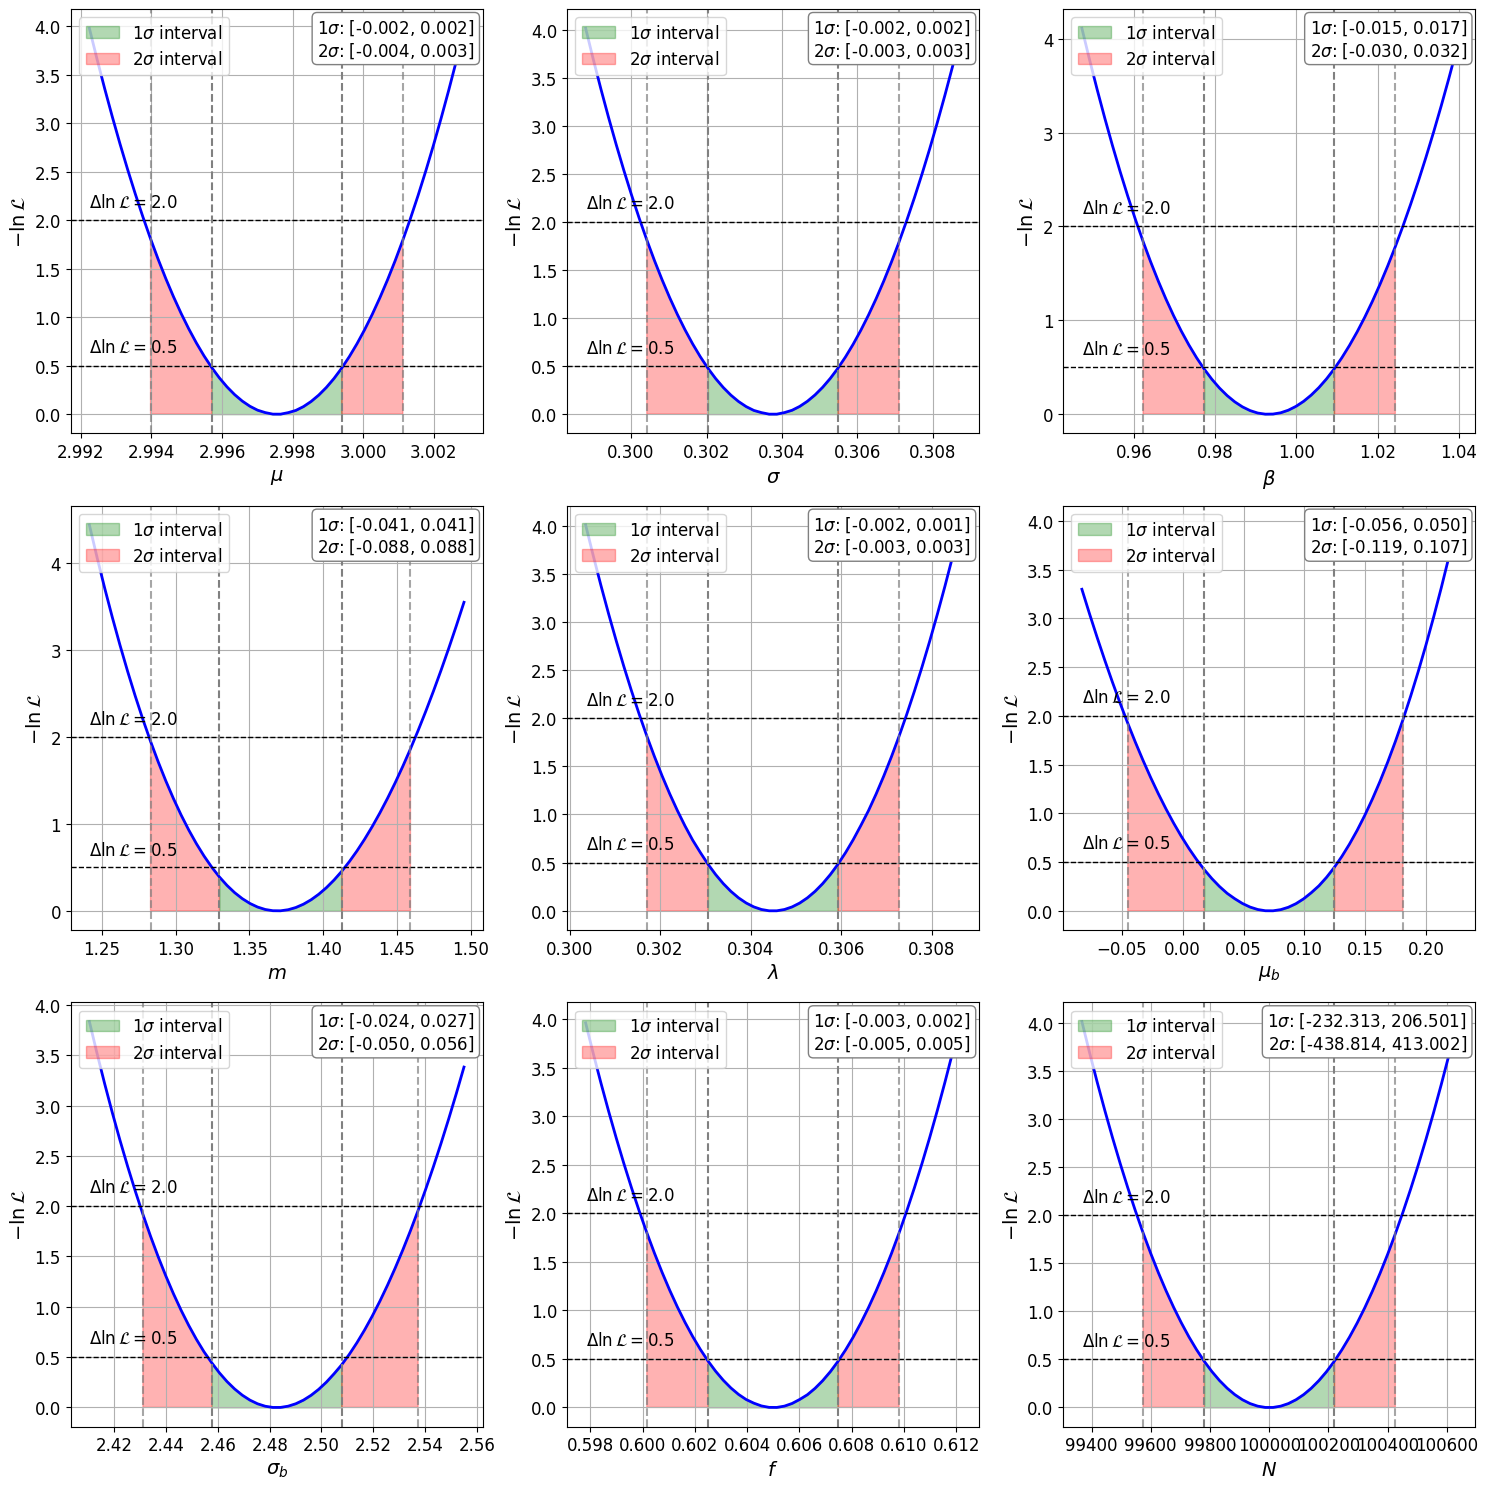

In [7]:
# This typically takes 10 mins to run
overall.plot_profiled_likelihoods()

### Analysis of Runtime




In [8]:
# Define the functions or use lambdas for statements
time_benchmark = timeit.timeit(lambda: np.random.normal(size=100000), number=100) / 100
print(f"Average time for benchmark: {time_benchmark:.6f} seconds")

# Measure time of Accept-Reject sampling for 100,000 samples - uses default values
time_generate = timeit.timeit(lambda: overall.accept_reject_sample(desired_samples=100000), number=100) / 100
print(f"Average time for Accept-Reject sampling: {time_generate:.6f} seconds")

# Measure time of fitting for 100,000 samples
initial_params = [3.1, 0.4, 1.1, 1.5, 0.4, 0.1, 2.6, 0.7, 99900]
generated_samples = overall.accept_reject_sample(desired_samples=100000, init_batch_size=1000, max_batch_size=2000000)
time_fitting = timeit.timeit(lambda: overall.fit_params(initial_params, samples=generated_samples), number=100) / 100
print(f"Average time for parameter fitting: {time_fitting:.6f} seconds")

Average time for benchmark: 0.002129 seconds
Average time for Accept-Reject sampling: 0.202977 seconds
Average time for parameter fitting: 5.825933 seconds


In [9]:
# Calculate relative times
generating_relative = time_generate / time_benchmark
fitting_relative = time_fitting / time_benchmark

# Print a table for the results
data_time = [
    ["Benchmark Process", time_benchmark, 1],
    ["Accept-Reject Sampling (Default)", time_generate, generating_relative],
    ["Fitting Parameters", time_fitting, fitting_relative],
]
headers = ["Process", "Average Time (s)", "Relative to Benchmark"]

print(tabulate(data_time, headers=headers, tablefmt="grid"))

+----------------------------------+--------------------+-------------------------+
| Process                          |   Average Time (s) |   Relative to Benchmark |
+==================================+====================+=========================+
| Benchmark Process                |         0.00212889 |                  1      |
+----------------------------------+--------------------+-------------------------+
| Accept-Reject Sampling (Default) |         0.202977   |                 95.3442 |
+----------------------------------+--------------------+-------------------------+
| Fitting Parameters               |         5.82593    |               2736.61   |
+----------------------------------+--------------------+-------------------------+
